**EXECUTE THIS NOTEBOOK IN COOLAB**

In [1]:
# importar librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Procesamiento de Datos

In [ ]:
#!curl https://raw.githubusercontent.com/LuisFelipePoma/PC2-IA/main/src/model/heart.csv -o heart.csv

In [2]:
# obtener el conjunto de datos
df = pd.read_csv('heart.csv')

In [3]:
df.columns

Index(['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh',
       'exng', 'oldpeak', 'slp', 'caa', 'thall', 'output'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [5]:
df.head(5)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


<Axes: >

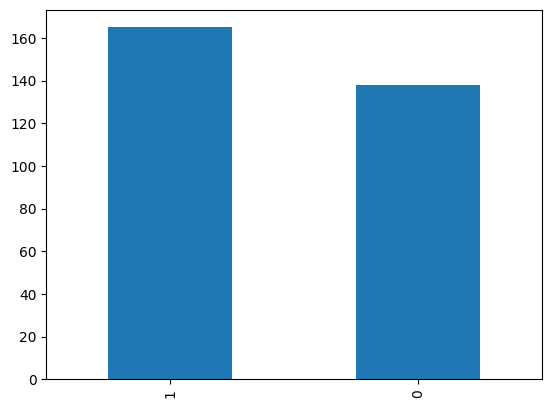

In [6]:
# see if the data is balance in a plot
df["output"].value_counts().plot(kind='bar')

In [7]:
# Verify if there are any null values
print(df.isna().sum())

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64


In [8]:
df.describe()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


## Transformación de Datos


In [9]:
from sklearn.preprocessing import LabelEncoder

# ---------------------> DROP DATA <---------------------

df.drop(
    columns=["chol", "fbs", "trtbps", "restecg", "slp", "oldpeak", "caa"],
    inplace=True,
)

# df = df.loc[df["thall"] != 0]

In [10]:
df.columns

Index(['age', 'sex', 'cp', 'thalachh', 'exng', 'thall', 'output'], dtype='object')

In [11]:
df.describe()

,age,sex,cp,thalachh,exng,thall,output
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,149.646865,0.326733,2.313531,0.544554
std,9.082101,0.466011,1.032052,22.905161,0.469794,0.612277,0.498835
min,29.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,133.500000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,153.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,166.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,202.000000,1.000000,3.000000,1.000000


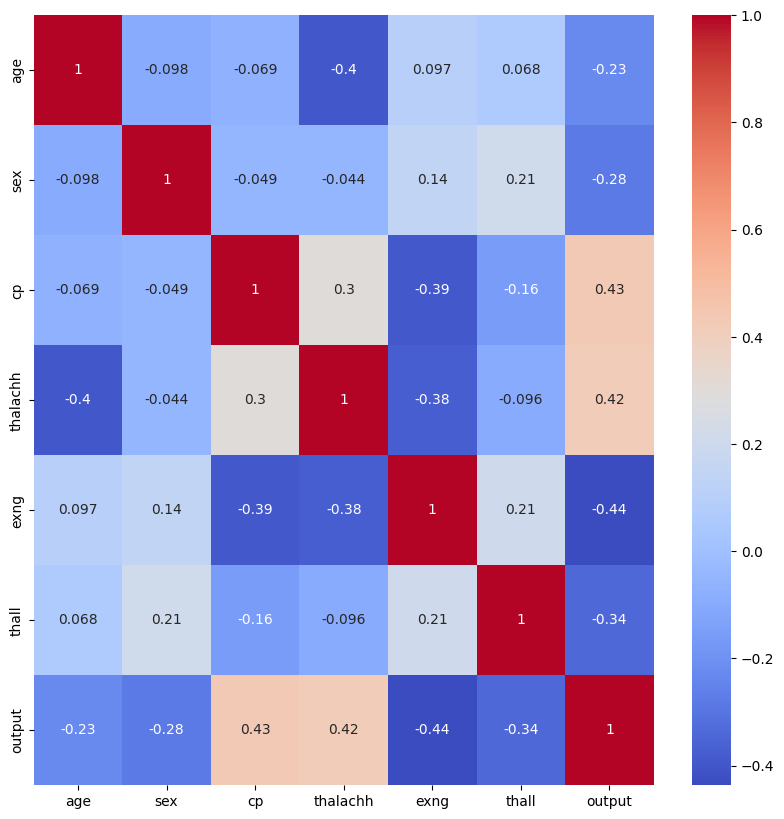

In [12]:
# graph of the corr
import seaborn as sns
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.show()

# Modelate

In [13]:
df.head()

,age,sex,cp,thalachh,exng,thall,output
0,63,1,3,150,0,1,1
1,37,1,2,187,0,2,1
2,41,0,1,172,0,2,1
3,56,1,1,178,0,2,1
4,57,0,0,163,1,2,1


## Split Data

In [14]:
# Split the dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    ConfusionMatrixDisplay,
)


X_train, X_test, y_train, y_test = train_test_split(
    df.drop("output", axis=1),
    df["output"],
    random_state=42,
    test_size=0.2,
)
# Path to save the models
PATH = "../client/public/models/"

In [15]:
# Eliminamos el Id del pasajero en el conjunto de datos de prueba
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((242, 6), (61, 6), (242,), (61,))

# Transfom Models

In [ ]:
#!pip install skl2onnx
#!pip install tensorflowjs

In [19]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import tensorflowjs as tfjs

def save_model(model, file):
    initial_type = [("input", FloatTensorType([1, X_train.shape[1]]))]
    onx = convert_sklearn(model, initial_types=initial_type)
    with open(PATH + file + ".onnx", "wb") as f:
        f.write(onx.SerializeToString())

## Model Perceptron


In [39]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input


In [42]:
perceptron = Sequential()

perceptron.add(Input(shape=(X_train.shape[1],)))
perceptron.add(Dense(units=1, activation="sigmoid"))
perceptron.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
perceptron.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 1)                 7         
                                                                 
Total params: 7 (28.00 Byte)
Trainable params: 7 (28.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = perceptron.fit(X_train, y_train, epochs=250, batch_size=8, verbose=1, validation_data=(X_test, y_test))
# save model and architecture to single file
#perceptron.save(PATH + "perceptron.h5")
tfjs.converters.save_keras_model(perceptron, "perceptron_model")

## Model Naive Bayes

In [23]:
from sklearn.naive_bayes import GaussianNB

In [24]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
save_model(gnb, "model_gnb")
y_pred = gnb.predict(X_test)
# print accuracy
acc_gnb = accuracy_score(y_test, y_pred)
print(acc_gnb)

0.8524590163934426


### CNN

In [25]:
# Import lib for convolutional neural network
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dropout

In [26]:
modelconv = Sequential()
# modelconv.add(tf.keras.Input(shape=(10,)))
modelconv.add(Conv1D(4, 3, activation="relu", input_shape=(X_train.shape[1], 1)))
modelconv.add(MaxPooling1D())
modelconv.add(Flatten())
modelconv.add(Dense(4, activation="relu"))
modelconv.add(Dropout(0.1))
modelconv.add(Dense(1, activation="sigmoid"))
modelconv.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
modelconv.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 4)              16        
                                                                 
 max_pooling1d (MaxPooling1  (None, 2, 4)              0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 4)                 36        
                                                                 
 dropout (Dropout)           (None, 4)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                      

In [27]:
# Train the model
historyconv = modelconv.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=500, batch_size=8
)
# save model to .h5
#modelconv.save( PATH + "modelconv.h5")
tfjs.converters.save_keras_model(perceptron, "cnn_model")


Epoch 1/500
31/31 [==============================] - 1s 11ms/step - loss: 4.9753 - accuracy: 0.4421 - val_loss: 0.8472 - val_accuracy: 0.5246
Epoch 2/500
31/31 [==============================] - 0s 4ms/step - loss: 2.5880 - accuracy: 0.5083 - val_loss: 0.6983 - val_accuracy: 0.5246
Epoch 3/500
31/31 [==============================] - 0s 4ms/step - loss: 2.8650 - accuracy: 0.5124 - val_loss: 0.6790 - val_accuracy: 0.5246
Epoch 4/500
31/31 [==============================] - 0s 4ms/step - loss: 2.7635 - accuracy: 0.5744 - val_loss: 0.6758 - val_accuracy: 0.7049
Epoch 5/500
31/31 [==============================] - 0s 4ms/step - loss: 2.4853 - accuracy: 0.5702 - val_loss: 0.6678 - val_accuracy: 0.7049
Epoch 6/500
31/31 [==============================] - 0s 4ms/step - loss: 2.3011 - accuracy: 0.5455 - val_loss: 0.6640 - val_accuracy: 0.5246
Epoch 7/500
31/31 [==============================] - 0s 4ms/step - loss: 2.1689 - accuracy: 0.5124 - val_loss: 0.6821 - val_accuracy: 0.5246
Epoch 8/500


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# graph of loss
plt.plot(historyconv.history['loss'])
plt.plot(historyconv.history['val_loss'])
plt.title('Loss vs Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()